# Single weight behavior

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pystan
import scipy.stats as stats
import seaborn as sns
import tqdm
import sys
import tensorflow as tf
from numpy import trapz

sns.set(style="whitegrid", font_scale=2.25)
sys.path.append('../')

try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #upload vimlts.py first
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_fast.py
    sys.path.append(".")
    from vimlts_fast import VimltsLinear, ConjungateDenseViGauss
except:
    IN_COLAB = False
    from src.vimlts_fast import VimltsLinear, ConjungateDenseViGauss

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import initializers
from functools import partial

print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version: ',tf.__version__, )
log=tf.math.log

--2021-09-24 11:12:34--  https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_fast.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14480 (14K) [text/plain]
Saving to: ‘vimlts_fast.py.5’

vimlts_fast.py.5    100%[===================>]  14.14K  --.-KB/s    in 0s      

2021-09-24 11:12:34 (71.3 MB/s) - ‘vimlts_fast.py.5’ saved [14480/14480]

--2021-09-24 11:12:34--  https://raw.githubusercontent.com/stefan1893/TM-VI/blob/main/ipynb/01_singel_weight_data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-09-24 1

In [2]:
epochs = 10000
optimizer=tf.keras.optimizers.RMSprop()
# Prior
prior_dist=tfd.Normal(loc=0.,scale=1.)

In [ ]:
#Mountung g-drive to download data
from google.colab import drive
drive.mount('/content/drive')

## Data generating process
Draw samples from a mixture distribution

$y \sim MixtureCauchy(\mu_{0},\sigma, \mu_{1},\sigma)$

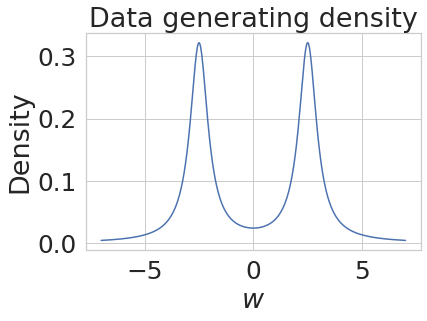

In [3]:
mu_0=2.5
mu_1=-2.5
sigma=sigma_0=sigma_1=0.5
mix=0.5

# Cauchy mixture distribution
a_bimix_cauchy = tfd.Mixture(
  cat=tfd.Categorical(probs=[mix, 1.-mix]),
  components=[
    tfd.Cauchy(loc=mu_0, scale=sigma_0),
    tfd.Cauchy(loc=mu_1, scale=sigma_1),
])

ww=np.linspace(-7.,7.,num=int(1e3))

plt.figure()
plt.plot(ww, a_bimix_cauchy.prob(ww))
plt.title(r'Data generating density')
plt.ylabel(r'Density')
plt.xlabel(r'$w$');

---- Using stored file ---


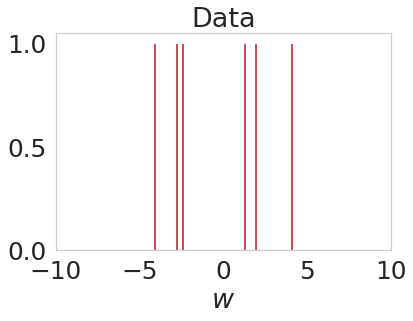

In [4]:
if (False):
    print('---- creating new data ---')
    num = 6
    tf.random.set_seed(2)
    y = a_bimix_cauchy.sample(sample_shape=num)
    y=np.array(y).reshape([-1])
    np.save(data_file, y)

y = np.array([1.2083935, -2.7329216,  4.1769943,  1.9710574, -4.2004027, -2.384988])
plt.hist(y, color='r',bins=50)
plt.xlim([-10,10])
plt.grid()
plt.title(r'Data')
plt.xlabel(r'$w$');

## Ground truth

In [5]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 50, zorder=1, density=True)
    sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [6]:
stan_code = """
data{
  int<lower=0> N;
  real<lower=0> sigma;
  vector[N] y;
}
parameters{
  real w;
}
model{
  y ~ cauchy(w, sigma);
  w ~ normal(0, 1);
}
"""

mcmc_model=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3e6c130a5f8167199a3e917cb6ec796 NOW.


In [7]:
mcmc_data = {'N': num,
        'sigma': sigma,
        'y': y}
mcmc_fit=mcmc_model.sampling(data=mcmc_data,iter=8000,chains=8)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


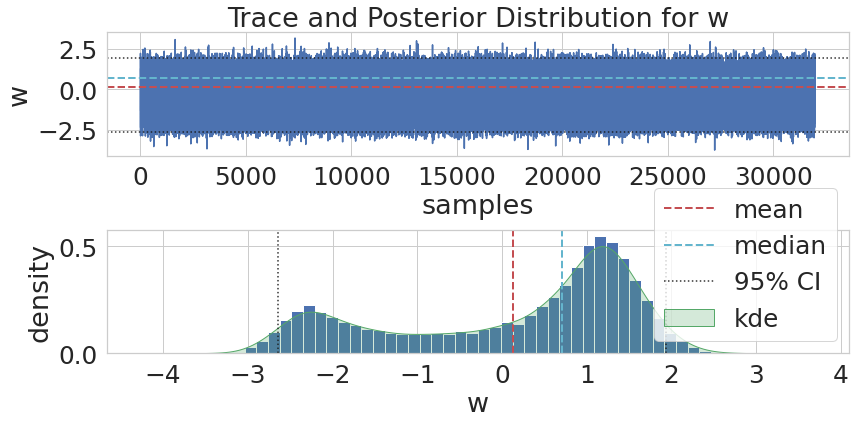

In [8]:
plt.figure(figsize=(12,6))
plot_trace(mcmc_fit.extract()['w'],"w")

In [9]:
print(mcmc_fit.stansummary())

Inference for Stan model: anon_model_b3e6c130a5f8167199a3e917cb6ec796.
8 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=32000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w      0.13    0.03   1.44  -2.64  -1.11   0.71   1.25   1.94   1931    1.0
lp__ -19.27    0.01   0.72 -20.51 -19.81 -19.29  -18.6  -18.4   4393    1.0

Samples were drawn using NUTS at Fri Sep 24 11:13:50 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Comparison with kde

1.8558880521074396e-08


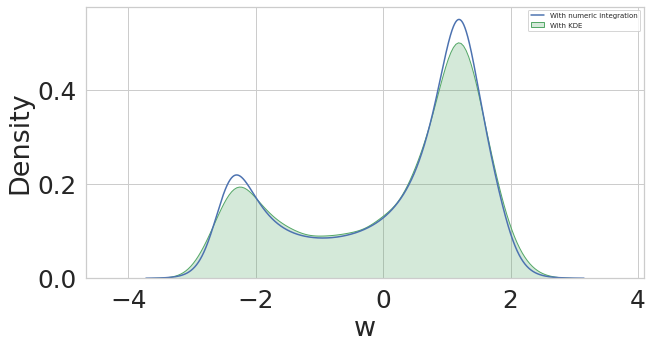

In [10]:
plt.figure(figsize=(10,5))
mcmc_p_w_D = np.exp(mcmc_fit.to_dataframe()['lp__'])
w_mcmc = mcmc_fit.to_dataframe()['w']
sort = np.argsort(w_mcmc)
# proportional
mcmc_p_w_D = mcmc_p_w_D[sort]
w_mcmc = w_mcmc[sort]
print(np.trapz(mcmc_p_w_D, w_mcmc))
mcmc_p_w_D /= np.trapz(mcmc_p_w_D, w_mcmc)
plt.plot(w_mcmc, mcmc_p_w_D, label="With numeric integration")
sns.kdeplot(w_mcmc, color='g',zorder=2, shade=True, label=r'With KDE')
plt.legend(fontsize='x-small')
# sns.kdeplot(w_mcmc, color='r',zorder=2, shade=True, label=r'kde', bw_method='silverman', bw_adjust=0.5)

In [32]:
#Saving
import pandas as pd
df = pd.DataFrame(data = [w_mcmc, mcmc_p_w_D]).transpose()
df.to_csv('/content/drive/MyDrive/tmp/transfer/mcmc_densities.csv.gz', compression='gzip', index=False)

## MFVI

### Create a model

In [12]:
ytensor = y.reshape([len(y),1])

def softplus_inv(y):
    return np.log(np.exp(y) - 1)

models = {}
theta_start = -5
theta_stop = 5
# Number of samples psi to approximate the expected value
num_samples=10000
Ms = [1,10,30]
for M in Ms:
    # init params
    kernel_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] + [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])
    # define model
    tf.random.set_seed(2)
    layer = VimltsLinear(1,
                         activation=lambda x: x,
                         **kernel_initializers,
                         num_samples=num_samples,
                         prior_dist=prior_dist,
                         input_shape=(1,))
    model = tf.keras.Sequential([layer], name=f"VIMLTS-degree{M}")
    model.build(input_shape=(None, 1))
    models[f"TM-VI, M={M}"] = model
model.summary()

class LogKL(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epochs'] = epoch
        # kl = [layer.losses[0] for layer in self.model.layers]
        # # logs['kl'] = tf.reduce_sum(kl)
        # logs['kl'] = kl

def scheduler(epoch, lr, lr_start, lr_stop, epochs):
    if epoch > epochs:
        return lr_stop
    else:
        return lr_start + (lr_stop-lr_start)*(epoch/epochs)

@tf.function
def sample_nll(y_obs, y_pred, scale=sigma):
    """
    Args:
        y_obs: true labels. Expected shape (#batch, 1) or (#batch)
        y_pred: model prediction. Expected shape (#samples, #batch, 1) or (#samples, #batch)

    Returns: sum of Nll
    """
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    tf.debugging.check_numerics(y_pred, "Prediction for nll computation contains NaNs or Infs")
    error_str = f"Expected one of the above defined shapes. Got shapes: y_obs: {y_obs.shape}; y_pred: {y_pred.shape}"
    assert y_pred.shape[-1] == y_obs.shape[-1] or ((len(y_pred.shape) == 3) and y_pred.shape[-1] == 1), error_str

    # dist = tfp.distributions.Normal(loc=y_pred, scale=scale)
    dist = tfd.Cauchy(loc=y_pred, scale=scale)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    tf.debugging.check_numerics(nlls, "NLL contains NaNs or Infs")
    return tf.reduce_sum(nlls)

Model: "VIMLTS-degree30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vimlts_linear_2 (VimltsLinea (10000, None, 1)          35        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [13]:
tf.random.set_seed(2)
vi_gauss_l = ConjungateDenseViGauss(1,
                                    activation=lambda x: x,
                                    num_samples=num_samples,
                                    kernel_init_mu_w = initializers.Constant(0.),
                                    kernel_init_rhosigma_w = initializers.Constant(softplus_inv(2.5)),
                                    prior_dist=prior_dist)
vi_gauss = tf.keras.Sequential([vi_gauss_l], name="Gauss-VI")
vi_gauss.build(input_shape=(None,1))
vi_gauss.summary()
models["Gauss-VI"] = vi_gauss

Model: "Gauss-VI"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conjungate_dense_vi_gauss (C (10000, None, 1)          2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,[[2.5]])


Text(0.5, 1.0, 'Posterior initial distribution')

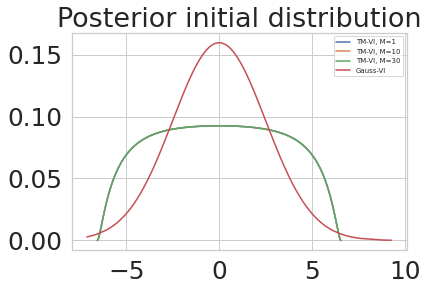

In [14]:
for name, model in models.items():
    layer = model.layers[0]
    qw, w = layer.get_w_dist()
    plt.plot(w, qw, label=name, linewidth=1.5)
plt.legend(fontsize='x-small')
plt.title("Posterior initial distribution")

### train the models

In [15]:
# Learning rate
lr_start=0.3
lr_end=0.1
epoch_lr_end = epochs // 2
for name, model in models.items():
    print(f"Start experiment with model {name}")
    lr_callback = tf.keras.callbacks.LearningRateScheduler(partial(scheduler, lr_start=lr_start, lr_stop=lr_end, epochs=epoch_lr_end))
    model.compile(optimizer, loss=sample_nll, run_eagerly=False)
    model.fit(tf.ones(ytensor.shape), ytensor, epochs=epochs, verbose=False, callbacks=[LogKL()])

Start experiment with model TM-VI, M=1
Start experiment with model TM-VI, M=10
Start experiment with model TM-VI, M=30
Start experiment with model Gauss-VI


VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.14891797]], dtype=float32)>,[[1.168884]])


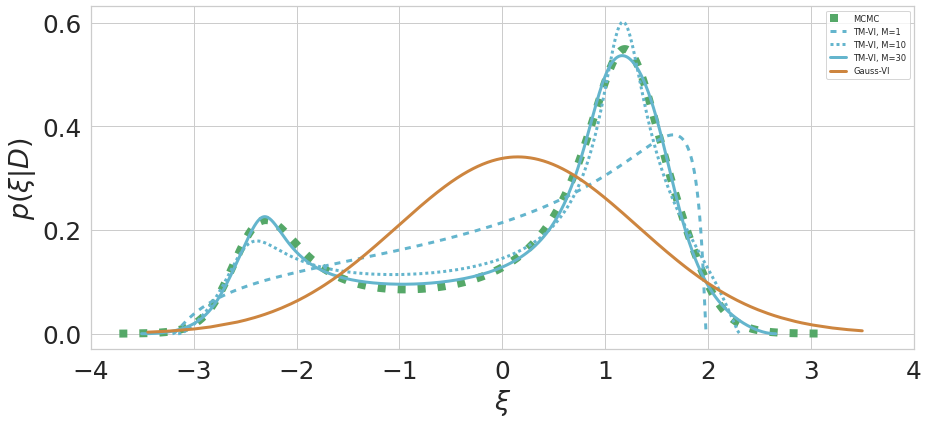

In [34]:
plt.figure(figsize=(13,6))
plt.plot(w_mcmc, mcmc_p_w_D, label=r"MCMC", linewidth=8., color='g', linestyle=(0, (1, 1.5)))
linestyles = [(0, (2, 2)), (0, (1, 1)), '-']
ls = 0
for name, model in models.items():
    layer = model.layers[0]
    qw, w = layer.get_w_dist()
    df = pd.DataFrame(data = [w, qw]).transpose()
    df.to_csv('/content/drive/MyDrive/tmp/transfer/{}_densities.csv.gz'.format(name), compression='gzip', index=False)
    if "TM-VI" in name:
        plt.plot(w, qw, label=name, linewidth=3., color='c', linestyle=linestyles[ls])
        ls += 1
    else:
        plt.plot(w, qw, label=name, linewidth=3., color='peru')
plt.legend(fontsize='small')
# plt.title("Posterior distribution $p(w|D)$")
plt.xlim((-4,4.))
plt.xlabel("$\\xi$")
plt.ylabel("$p(\\xi|D)$")
plt.tight_layout()
plt.savefig("02_cauchy_posterior.pdf")

In [21]:
'{}densities.csv.gz'.format('Hallo')

'Hallodensities.csv.gz'

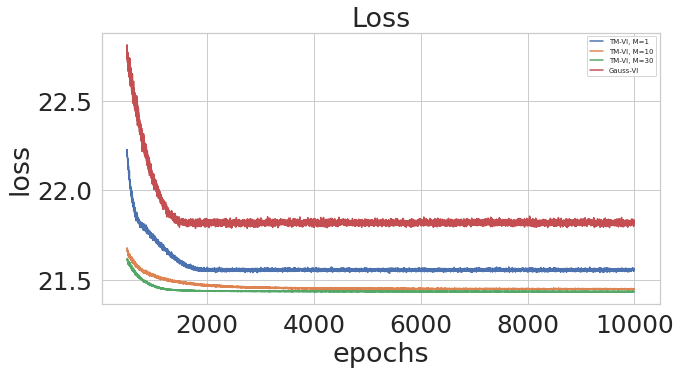

In [37]:
plt.figure(figsize=(10,5))
for m, model in models.items():
    plt.plot(model.history.history['epochs'][500:], model.history.history['loss'][500:], label=m)
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize='x-small')

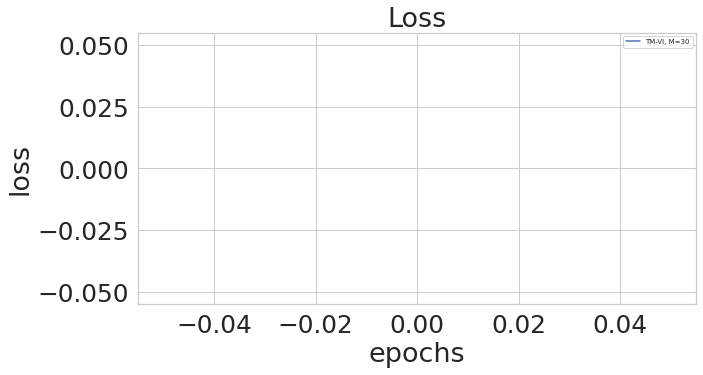

In [36]:
plt.figure(figsize=(10,5))
model = models['TM-VI, M=30']
plt.plot(model.history.history['epochs'][10000:], model.history.history['loss'][10000:], label='TM-VI, M=30')
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize='x-small')